In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
from IPython.display import display
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as log_progress
from graphviz import Digraph
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

#plt.rcParams['figure.figsize'] = 12, 10
#plt.rcParams.update({'font.size': 16})
pd.options.display.max_rows = 20

In [2]:
TASK_TYPE_TRACE = 1
TASK_TYPE_SHADE = 2

def parse_trace_per_path_line(line):
    data = np.fromstring(line, dtype=int, sep=' ')
    pathID = data[0]
    rows = data[1:].reshape(-1, 5)
    nodes = {-1: dict(elapsed=0, depth=0, treeletID=None, isLeaf=False, childCnt=0)}
    for nodeID,prevNodeID,treeletID,runtime,bvhNodesVisited in rows:
        nodes[prevNodeID]['childCnt'] += 1
        if nodes[prevNodeID]['childCnt'] > 1: nodes[prevNodeID]['taskType'] = TASK_TYPE_SHADE
        nodes[prevNodeID]['isLeaf'] = False
        prev = nodes[prevNodeID]
        nodes[nodeID] = dict(prevNodeID=prevNodeID, runtime=runtime, treeletID=treeletID, isLeaf=True,
                            elapsed = prev['elapsed'] + runtime, bvhNodesVisited=bvhNodesVisited,
                            childCnt = 0, taskType = TASK_TYPE_TRACE,
                            depth = prev['depth'] + (1 if treeletID != prev['treeletID'] else 0)
                            )
    del nodes[-1]
    lastNodeID = max(nodes.keys(), key=lambda nodeID: nodes[nodeID]['elapsed'])
    pathInfo = dict(pathID=pathID, nodes=nodes, lastNodeID=lastNodeID)
    return pathInfo

def parse_profiling(out_dir):
    parsed = dict(name=os.path.basename(out_dir))
    
    treelet_sizes_fn = os.path.join(out_dir, 'treelet_sizes.txt')
    with open(treelet_sizes_fn, 'r') as f:
        treelet_sizes = dict(tuple(int(x) for x in l.split()) for l in f)
    parsed['treelet_sizes'] = treelet_sizes
    
    node_cnt_fn = os.path.join(out_dir, 'node_cnt_for_treelet.txt')
    if os.path.isfile(node_cnt_fn):
        with open(treelet_sizes_fn, 'r') as f:
            treelet_node_cnt = dict(tuple(int(x) for x in l.split()) for l in f)
    else:
        treelet_node_cnt = dict(zip(treelet_sizes.keys(), range(len(treelet_sizes))))
    parsed['treelet_node_cnt'] = treelet_node_cnt
  
    parsed['trace_fn'] = os.path.join(out_dir, 'trace_per_path.txt')
    num_lines = sum(1 for line in open(parsed['trace_fn']))
    longest, tasks = [], []
    with open(parsed['trace_fn'], 'r') as f:
        for l in log_progress(f, total=num_lines, desc='Paths'):
            pathInfo = parse_trace_per_path_line(l)
            pathID = pathInfo['pathID']
            n = pathInfo['nodes'][pathInfo['lastNodeID']]
            longest.append((pathID, n['depth'], n['elapsed']))
            tasks += [(pathID, nodeID,
                       n['prevNodeID'], n['treeletID'], n['runtime'], n['bvhNodesVisited'], n['taskType'],
                                       treelet_sizes[n['treeletID']], treelet_node_cnt[n['treeletID']])
                          for nodeID,n in pathInfo['nodes'].items()]
    parsed['longest'] = (pd.DataFrame(longest, columns=['pathID', 'depth', 'elapsed'])
                .sort_values(by=['elapsed'], ascending=[True], kind='mergesort').reset_index(drop=True))
    parsed['tasks'] = pd.DataFrame(tasks,
                        columns=['pathID', 'nodeID', 'prevNodeID', 'treeletID', 'runtime', 'bvhNodesVisited',
                                 'taskType', 'treeletSize', 'treeletNodes'])
    
    parsed['perf_stats_fn'] = os.path.join(out_dir, 'perf_stats.txt')
    parsed['perf'] = None
    if os.path.isfile(parsed['perf_stats_fn']):
        task_cols2 = parsed['tasks'].columns.difference(['taskType'])
        perf_cols = ['pathID', 'nodeID', 'taskType', 'p50l1dAccess', 'p99l1dAccess','p50l1dMissRate', 'p99l1dMissRate', 'p50Ipc', 'p99Ipc']
        # XXX The perf stats file may have fewer tasks than found in the entire trace (tasks_df) 
        parsed['perf'] = (pd.read_csv(parsed['perf_stats_fn'], sep=' ', header=None, names=perf_cols)
                .merge(parsed['tasks'][task_cols2], on=['pathID', 'nodeID']))
        
    return parsed

def load_path(parsed, pathID):
    nodes = {-1: dict(elapsed=0, depth=0, treeletID=None, isLeaf=False)}
    for i,r in parsed['tasks'][parsed['tasks'].pathID == pathID].sort_values(by=['nodeID']).iterrows():
        nodes[r.prevNodeID]['isLeaf'] = False
        prev = nodes[r.prevNodeID]
        nodes[r.nodeID] = dict(prevNodeID=r.prevNodeID, runtime=r.runtime, treeletID=r.treeletID, isLeaf=True,
                            elapsed = prev['elapsed'] + r.runtime, bvhNodesVisited=r.bvhNodesVisited,
                            depth = prev['depth'] + (1 if r.treeletID != prev['treeletID'] else 0)
                            )
    del nodes[-1]
    lastNodeID = max(nodes.keys(), key=lambda nodeID: nodes[nodeID]['elapsed'])
    pathInfo = dict(pathID=pathID, nodes=nodes, lastNodeID=lastNodeID)
    if 'perf' in parsed and parsed['perf'] is not None:
        for i,r in parsed['perf'][parsed['perf'].pathID == pathID].iterrows():
            pathInfo['nodes'][r.nodeID]['perf'] = dict(taskType=r.taskType, p50l1dAccess=r.p50l1dAccess,
                                                          p50l1dMissRate=r.p50l1dMissRate, p50Ipc=r.p50Ipc)
    for i,r in parsed['tasks'][parsed['tasks'].pathID == pathID].iterrows():
        pathInfo['nodes'][r.nodeID]['treeletSize'] = r.treeletSize
    return pathInfo

def show_path(parsed, pathInfo, saveFile=False):
    dot = Digraph()
    dot.node('legend', 'treeletID (size), compute time\n[depth from root, elapsed from root]\ncache accesses, misses, IPC')
    for nodeID,node in pathInfo['nodes'].items():
        if nodeID == -1: continue
        lbl = "%d (%dKB), %dns" % (node['treeletID'], node['treeletSize']/1024, node['runtime'])
        if node['isLeaf']:
            lbl += "\ndepth: %d, elapsed: %dns" % (node['depth'], node['elapsed'])
        if 'perf' in node:
            p = node['perf']
            lbl += "\naccesses: %d, miss: %.2f%%, IPC: %.2f" % (p['p50l1dAccess'], p['p50l1dMissRate']*100, p['p50Ipc'])
            
        dot.node(str(nodeID), lbl)
        if node['prevNodeID'] != -1:
            dot.edge(str(node['prevNodeID']), str(nodeID))
    if saveFile:
        dot.format = 'png'
        dot.render('%s_path%d'%(parsed['name'], pathInfo['pathID']))
    return dot

In [3]:
%%time
bmw16k_parsed = parse_profiling('../build/out/bmw16k')

Paths:   0%|          | 0/1400000 [00:00<?, ?it/s]

CPU times: user 7min 26s, sys: 30.5 s, total: 7min 56s
Wall time: 7min 55s


Number of tasks: 174844


<IPython.core.display.Javascript object>


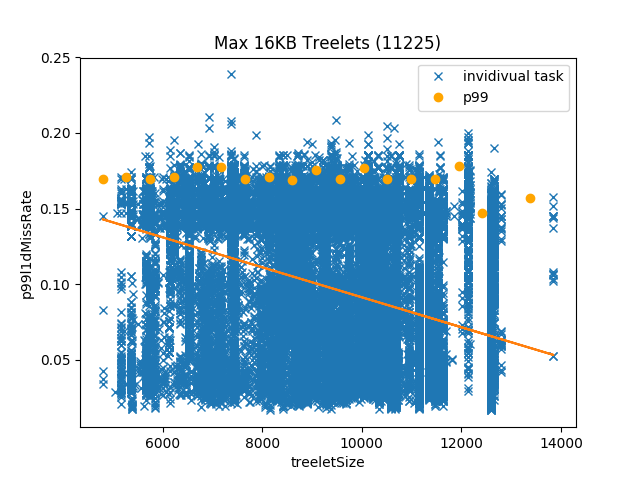

Text(0.5, 1.0, 'Max 16KB Treelets (11225)')

In [4]:
df = bmw16k_parsed['perf'][bmw16k_parsetd['perf'].taskType == TASK_TYPE_TRACE]
xcol = 'treeletSize'
#xcol = 'bvhNodesVisited'
#xcol = 'runtime'
#ycol = 'p99l1dAccess'
#ycol = 'p50l1dAccess'
ycol = 'p50l1dMissRate'
ycol = 'p99l1dMissRate'
#ycol = 'p50Ipc'
#ycol = 'p99Ipc'
#ycol = 'runtime'
#ycol = 'bvhNodesVisited'
x = df[xcol].values.reshape(-1, 1)
y = df[ycol].values.reshape(-1, 1)
print("Number of tasks:", len(x))
polynomial_features = PolynomialFeatures(degree=1)
xp = polynomial_features.fit_transform(x)
model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

qntl = 99
bins = np.linspace(df[xcol].min(), df[xcol].max(), 20)
binned_df = (df.groupby(pd.cut(df[xcol], bins, labels=bins[:-1]))
        .agg({ycol: lambda ys: np.percentile(ys, q=qntl)})
        .reset_index(drop=False).astype(float))

plt.figure()

plt.plot(x, y, 'x', label='invidivual task')
plt.plot(binned_df[xcol], binned_df[ycol], 'o', color='orange', label='p%d'%qntl)
plt.plot(x,ypred)
plt.xlabel(xcol)
plt.ylabel(ycol)
plt.legend()
plt.title("Max 16KB Treelets (%d)" % len(bmw16k_parsed['treelet_sizes']))

30007765
1274


<IPython.core.display.Javascript object>


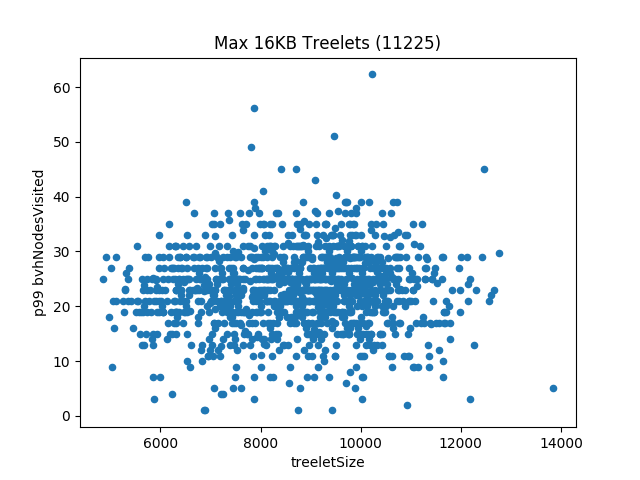

Text(0.5, 1.0, 'Max 16KB Treelets (11225)')

In [31]:
xcol = 'treeletSize'
#xcol = 'treeletID'
#ycol = 'runtime'
ycol = 'bvhNodesVisited'
#ycol = 'p99l1dAccess'
qntl = 99

#df = bmw16k_parsed['perf'][bmw16k_parsed['perf'].taskType == TASK_TYPE_TRACE]
df = bmw16k_parsed['tasks'][bmw16k_parsed['tasks'].taskType == TASK_TYPE_TRACE]
print(len(df))
#df2 = df.groupby(xcol, as_index=False)[[ycol]]
df2 = df.groupby(xcol)[[ycol]]
#df2.count()[df2 > 10]
df3 = df2.count()
df4 = df3[df3[ycol] > 1000]
df4 = df4.reset_index(drop=False)
treelet_sizes = df4[xcol]
print(len(treelet_sizes))

df5 = df[df[xcol].isin(treelet_sizes)]

df6 = (df5.groupby(xcol, as_index=False).agg({ycol:  lambda x: np.percentile(x, q=qntl)}))
df6.plot(x=xcol, y=ycol, kind='scatter')
plt.xlabel(xcol)
plt.ylabel('p%d %s' % (qntl, ycol))
plt.title("Max 16KB Treelets (%d)" % len(bmw16k_parsed['treelet_sizes']))

<IPython.core.display.Javascript object>


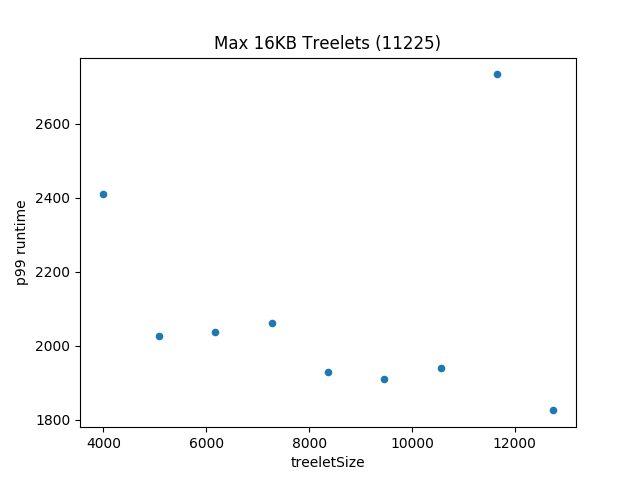

Text(0.5, 1.0, 'Max 16KB Treelets (11225)')

In [24]:
xcol = 'treeletSize'
#xcol = 'treeletID'
ycol = 'runtime'
#ycol = 'bvhNodesVisited'
qntl = 99

df = bmw16k_parsed['tasks'][bmw16k_parsed['tasks'].taskType == TASK_TYPE_TRACE]
bins = np.linspace(df[xcol].min(), df[xcol].max(), 10)
df = (df.groupby(pd.cut(df[xcol], bins, labels=bins[:-1]))
        .agg({ycol:  lambda x: np.percentile(x, q=qntl)})
        .reset_index(drop=False).astype(float))

df.plot(x=xcol, y=ycol, kind='scatter')
plt.xlabel(xcol)
plt.ylabel('p%d %s' % (qntl, ycol))
plt.title("Max 16KB Treelets (%d)" % len(bmw16k_parsed['treelet_sizes']))

<IPython.core.display.Javascript object>


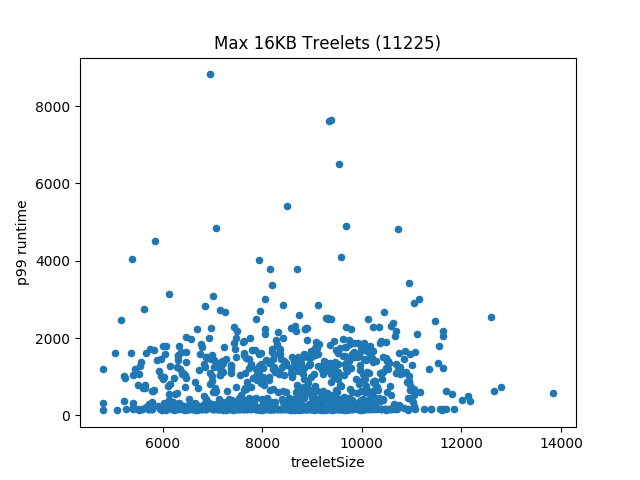

Text(0.5, 1.0, 'Max 16KB Treelets (11225)')

In [8]:
xcol = 'treeletSize'
#xcol = 'bvhNodesVisited'
#xcol = 'runtime'
#ycol = 'l1dAccess'
#ycol = 'l1dMissRate'
#ycol = 'ipc'
ycol = 'runtime'
#ycol = 'bvhNodesVisited'
qntl=99

df = bmw16k_parsed['perf'][bmw16k_parsed['perf'].taskType == TASK_TYPE_TRACE]
df = (df.groupby(xcol, as_index=False).agg({ycol:  lambda x: np.percentile(x, q=qntl)}))#(ycol, lambda x: np.percentile(x, q=qntl))))

#plt.figure()
#df = df.reset_index()
#df.columns = df.columns.droplevel(1)
#print(df.head())
df.plot(x=xcol, y=ycol, kind='scatter')
#plt.plot(x, y, 'x', label='invidivual task')
#plt.plot(x2, y2, 'o', color='orange', label='p%'%(qntl*100))
#plt.plot(x,ypred)
plt.xlabel(xcol)
plt.ylabel('p%d %s' % (qntl, ycol))
#plt.legend()
plt.title("Max 16KB Treelets (%d)" % len(bmw16k_parsed['treelet_sizes']))

In [9]:
pathID = 434246
pathInfo = load_path(bmw16k_parsed, pathID)

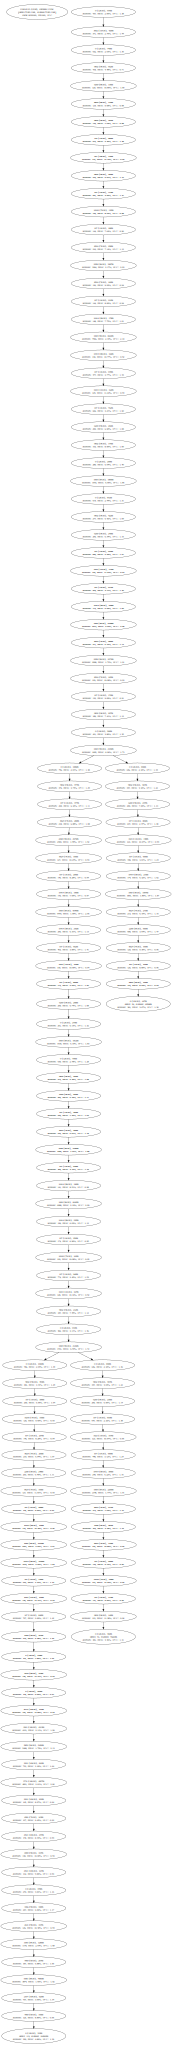

In [10]:
show_path(bmw16k_parsed, pathInfo, saveFile=True)

<IPython.core.display.Javascript object>


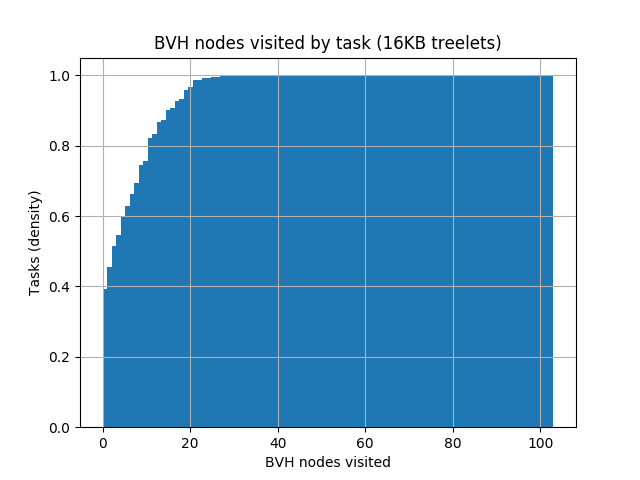

Text(0.5, 1.0, 'BVH nodes visited by task (16KB treelets)')

In [12]:
df = bmw16k_parsed['tasks'][bmw16k_parsed['tasks'].taskType == TASK_TYPE_TRACE]
plt.figure()
df.bvhNodesVisited.hist(cumulative=True, density=1, bins=100)
plt.xlabel('BVH nodes visited')
plt.ylabel('Tasks (density)')
plt.title("BVH nodes visited by task (16KB treelets)")
#plt.xlim(0, 20)

In [11]:
%%time
bmw512k_parsed = parse_profiling('../build/out/bmw512k')

Paths:   0%|          | 0/1400000 [00:00<?, ?it/s]

CPU times: user 7min 46s, sys: 27.3 s, total: 8min 13s
Wall time: 8min 14s


<IPython.core.display.Javascript object>


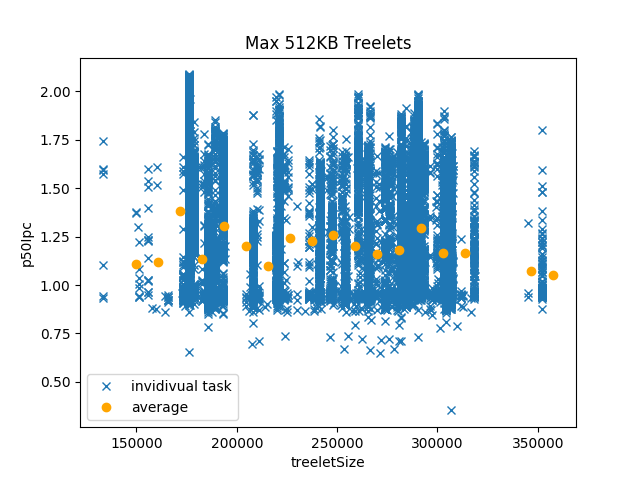

Text(0.5, 1.0, 'Max 512KB Treelets')

In [12]:
df = bmw512k_parsed['perf'][bmw512k_parsed['perf'].taskType == TASK_TYPE_TRACE]
xcol = 'treeletSize'
#xcol = 'bvhNodesVisited'
#ycol = 'l1dAccess'
#ycol = 'l1dMissRate'
ycol = 'p99Ipc'
ycol = 'p50Ipc'
#ycol = 'bvhNodesVisited'
x = df[xcol].values.reshape(-1, 1)
y = df[ycol].values.reshape(-1, 1)

polynomial_features = PolynomialFeatures(degree=1)
xp = polynomial_features.fit_transform(x)
model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

step = int((df[xcol].max() - df[xcol].min()) / 20)
x2, y2 = [], []
for i in range(int(df[xcol].min()), int(df[xcol].max()), step):
    x2.append(i + (step / 2))
    y2.append(df[(df[xcol] > i) & (df[xcol] < i+step)][ycol].mean())
 
plt.figure()
plt.plot(x, y, 'x', label='invidivual task')
plt.plot(x2, y2, 'o', color='orange', label='average')
#plt.plot(x,ypred)
plt.xlabel(xcol)
plt.ylabel(ycol)
plt.legend()
plt.title("Max 512KB Treelets")

<IPython.core.display.Javascript object>


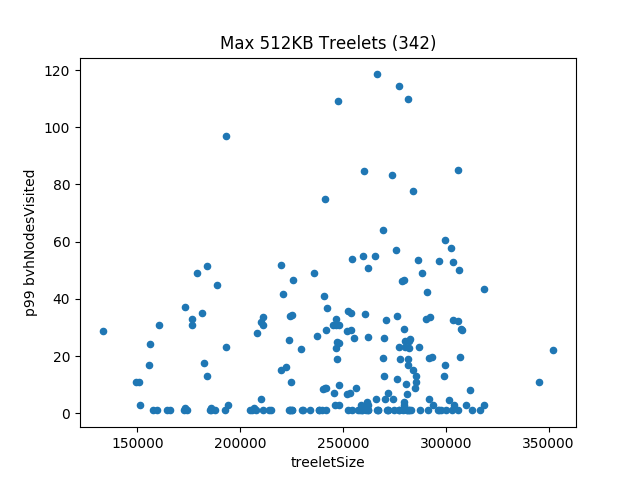

Text(0.5, 1.0, 'Max 512KB Treelets (342)')

In [13]:
xcol = 'treeletSize'
#xcol = 'bvhNodesVisited'
#xcol = 'runtime'
#ycol = 'l1dAccess'
#ycol = 'l1dMissRate'
#ycol = 'ipc'
#ycol = 'runtime'
ycol = 'bvhNodesVisited'

qntl=99
df = (bmw512k_parsed['perf'][bmw512k_parsed['perf'].taskType == TASK_TYPE_TRACE]
                    .groupby(xcol, as_index=False).agg({ycol:  lambda x: np.percentile(x, q=qntl)}))#(ycol, lambda x: np.percentile(x, q=qntl))))

df.plot(x=xcol, y=ycol, kind='scatter')
plt.xlabel(xcol)
plt.ylabel('p%d %s' % (qntl, ycol))
plt.title("Max 512KB Treelets (%d)" % len(bmw512k_parsed['treelet_sizes']))

<IPython.core.display.Javascript object>


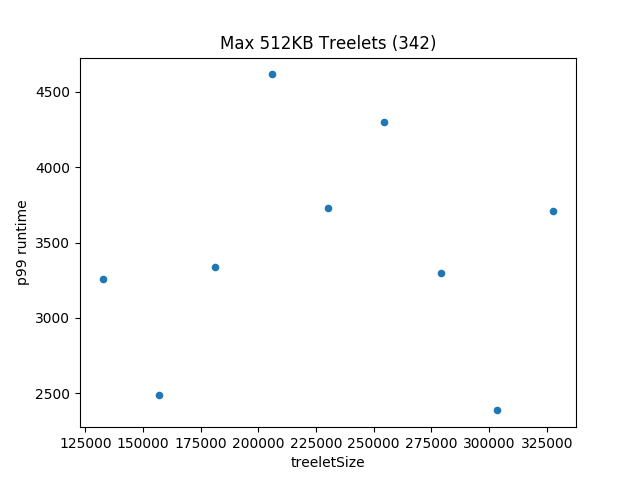

Text(0.5, 1.0, 'Max 512KB Treelets (342)')

In [34]:
xcol = 'treeletSize'
#xcol = 'treeletID'
ycol = 'runtime'
#ycol = 'bvhNodesVisited'
qntl = 99

df = bmw512k_parsed['tasks'][bmw512k_parsed['tasks'].taskType == TASK_TYPE_TRACE]
bins = np.linspace(df[xcol].min(), df[xcol].max(), 10)
df = (df.groupby(pd.cut(df[xcol], bins, labels=bins[:-1]))
        .agg({ycol:  lambda x: np.percentile(x, q=qntl)})
        .reset_index(drop=False).astype(float))

df.plot(x=xcol, y=ycol, kind='scatter')
plt.xlabel(xcol)
plt.ylabel('p%d %s' % (qntl, ycol))
plt.title("Max 512KB Treelets (%d)" % len(bmw512k_parsed['treelet_sizes']))

30007765
1274


<IPython.core.display.Javascript object>


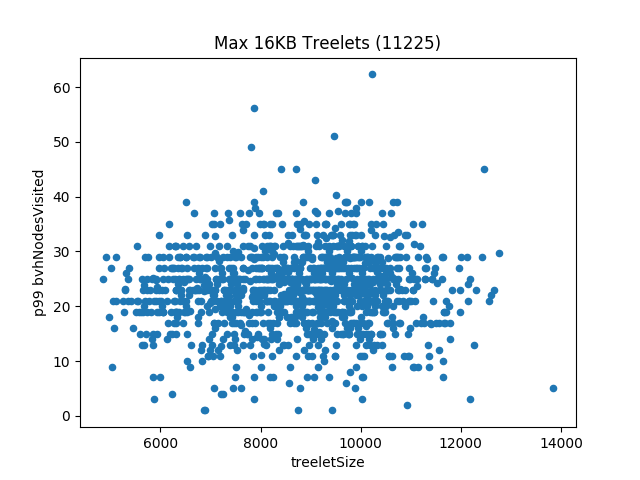

Text(0.5, 1.0, 'Max 16KB Treelets (11225)')

In [31]:
xcol = 'treeletSize'
#xcol = 'treeletID'
#ycol = 'runtime'
ycol = 'bvhNodesVisited'
#ycol = 'p99l1dAccess'
qntl = 99

#df = bmw16k_parsed['perf'][bmw16k_parsed['perf'].taskType == TASK_TYPE_TRACE]
df = bmw512k_parsed['tasks'][bmw512k_parsed['tasks'].taskType == TASK_TYPE_TRACE]
print(len(df))
#df2 = df.groupby(xcol, as_index=False)[[ycol]]
df2 = df.groupby(xcol)[[ycol]]
#df2.count()[df2 > 10]
df3 = df2.count()
df4 = df3[df3[ycol] > 1000]
df4 = df4.reset_index(drop=False)
treelet_sizes = df4[xcol]
print(len(treelet_sizes))

df5 = df[df[xcol].isin(treelet_sizes)]

df6 = (df5.groupby(xcol, as_index=False).agg({ycol:  lambda x: np.percentile(x, q=qntl)}))
df6.plot(x=xcol, y=ycol, kind='scatter')
plt.xlabel(xcol)
plt.ylabel('p%d %s' % (qntl, ycol))
plt.title("Max 512KB Treelets (%d)" % len(bmw512k_parsed['treelet_sizes']))

In [14]:
pathID = 434246
pathInfo = load_path(bmw512k_parsed, pathID)

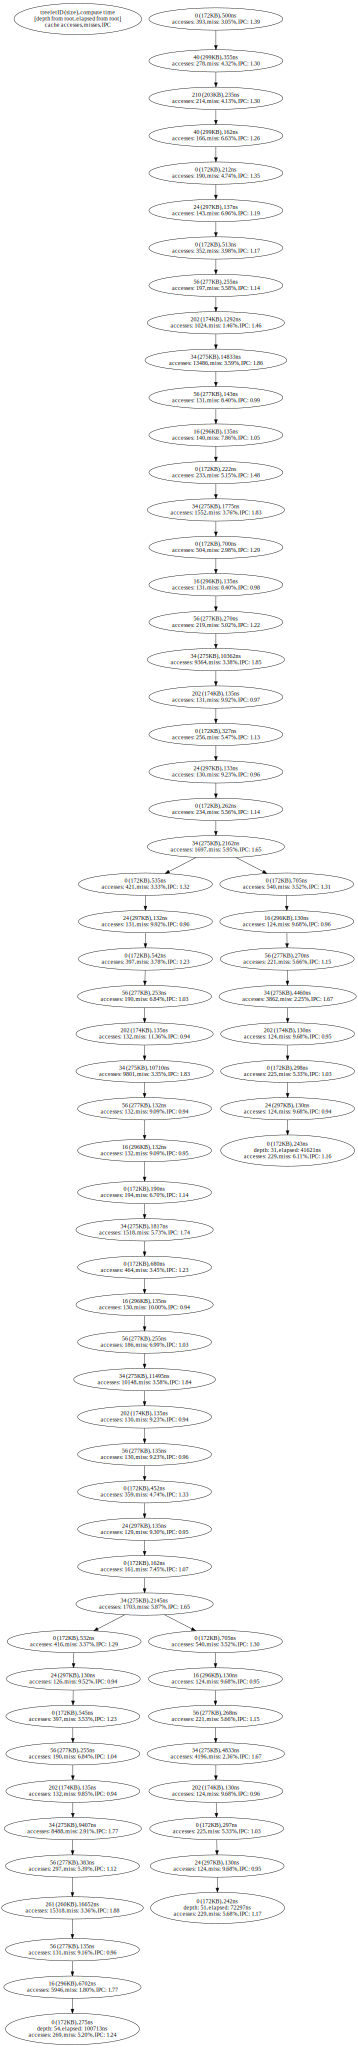

In [15]:
show_path(bmw512k_parsed, pathInfo, saveFile=True)

<IPython.core.display.Javascript object>


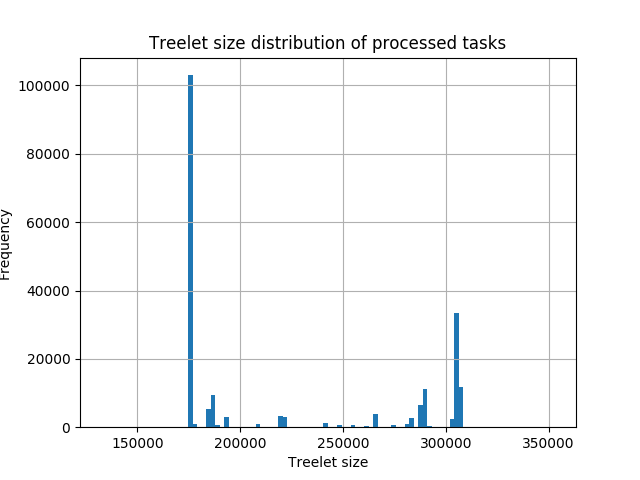

Text(0.5, 1.0, 'Treelet size distribution of processed tasks')

In [16]:
df = bmw512k_parsed['perf'][bmw512k_parsed['perf'].taskType == TASK_TYPE_TRACE]
plt.figure()
df.treeletSize.hist(bins=100)
plt.xlabel('Treelet size')
plt.ylabel('Number of tasks')
plt.title("Treelet size distribution of processed tasks")

<IPython.core.display.Javascript object>


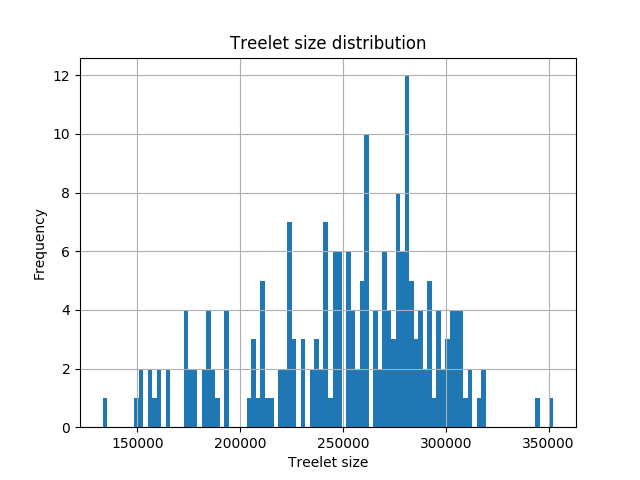

Text(0.5, 1.0, 'Treelet size distribution')

In [17]:
df = bmw512k_parsed['perf']
plt.figure()
df.groupby('treeletID').first().treeletSize.hist(bins=100)
plt.xlabel('Treelet size')
plt.ylabel('Frequency')
plt.title("Treelet size distribution")

In [18]:
%%time
bmw128k_parsed = parse_profiling('../build/out/bmw128k')

Paths:   0%|          | 0/1400000 [00:00<?, ?it/s]

CPU times: user 5min 52s, sys: 20.5 s, total: 6min 12s
Wall time: 6min 13s


<IPython.core.display.Javascript object>


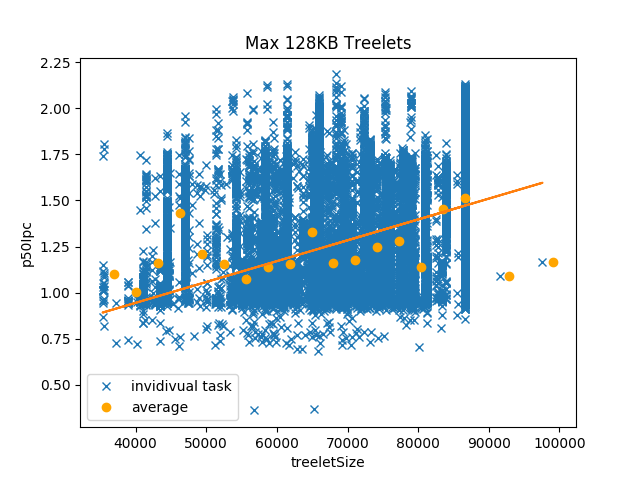

Text(0.5, 1.0, 'Max 128KB Treelets')

In [19]:
df = bmw128k_parsed['perf'][bmw128k_parsed['perf'].taskType == TASK_TYPE_TRACE]
xcol = 'treeletSize'
#ycol = 'l1dAccess'
ycol = 'l1dMissRate'
ycol = 'p50Ipc'
x = df[xcol].values.reshape(-1, 1)
y = df[ycol].values.reshape(-1, 1)

polynomial_features = PolynomialFeatures(degree=1)
xp = polynomial_features.fit_transform(x)
model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

step = int((df[xcol].max() - df[xcol].min()) / 20)
x2, y2 = [], []
for i in range(int(df[xcol].min()), int(df[xcol].max()), step):
    x2.append(i + (step / 2))
    y2.append(df[(df[xcol] > i) & (df[xcol] < i+step)][ycol].mean())
 
plt.figure()
plt.plot(x, y, 'x', label='invidivual task')
plt.plot(x2, y2, 'o', color='orange', label='average')
plt.plot(x,ypred)
plt.xlabel(xcol)
plt.ylabel(ycol)
plt.legend()
plt.title("Max 128KB Treelets")

In [20]:
%%time
bmw1m_parsed = parse_profiling('../build/out/bmw1m')

Paths:   0%|          | 0/1400000 [00:00<?, ?it/s]

CPU times: user 7min 6s, sys: 30.1 s, total: 7min 36s
Wall time: 7min 36s


<IPython.core.display.Javascript object>


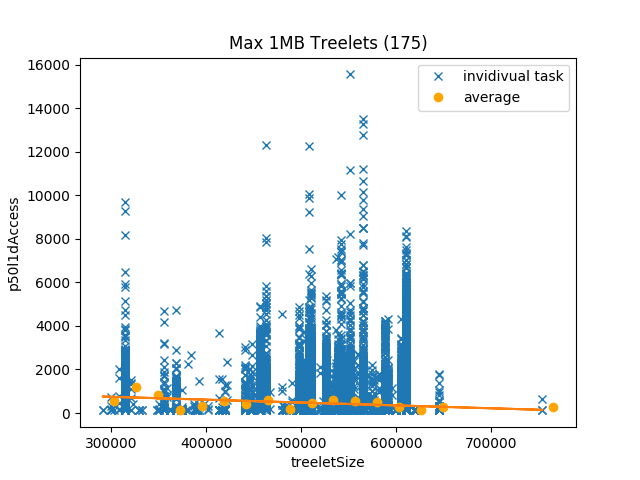

Text(0.5, 1.0, 'Max 1MB Treelets (175)')

In [33]:
df = bmw1m_parsed['perf'][bmw1m_parsed['perf'].taskType == TASK_TYPE_TRACE]
xcol = 'treeletSize'
ycol = 'p50l1dAccess'
#ycol = 'l1dMissRate'
#ycol = 'ipc'
x = df[xcol].values.reshape(-1, 1)
y = df[ycol].values.reshape(-1, 1)

polynomial_features = PolynomialFeatures(degree=1)
xp = polynomial_features.fit_transform(x)
model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

step = int((df[xcol].max() - df[xcol].min()) / 20)
x2, y2 = [], []
for i in range(int(df[xcol].min()), int(df[xcol].max()), step):
    x2.append(i + (step / 2))
    y2.append(df[(df[xcol] > i) & (df[xcol] < i+step)][ycol].mean())

plt.figure()
plt.plot(x, y, 'x', label='invidivual task')
plt.plot(x2, y2, 'o', color='orange', label='average')
plt.plot(x,ypred)
plt.xlabel(xcol)
plt.ylabel(ycol)
plt.legend()
plt.title("Max 1MB Treelets (%d)" % len(bmw1m_parsed['treelet_sizes']))

In [13]:
%%time
bmw10m_parsed = parse_profiling('../build/out/bmw10m')

Paths:   0%|          | 0/1400000 [00:00<?, ?it/s]

CPU times: user 3min 57s, sys: 12.9 s, total: 4min 10s
Wall time: 4min 9s


<IPython.core.display.Javascript object>


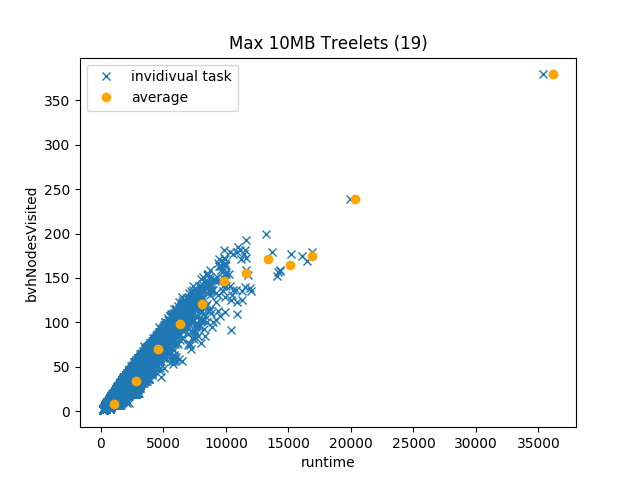

Text(0.5, 1.0, 'Max 10MB Treelets (19)')

In [32]:
df = bmw10m_parsed['perf'][bmw10m_parsed['perf'].taskType == TASK_TYPE_TRACE]
#xcol = 'treeletSize'
xcol = 'runtime'
ycol = 'l1dAccess'
#ycol = 'l1dMissRate'
#ycol = 'ipc'
#ycol = 'runtime'
ycol = 'bvhNodesVisited'
x = df[xcol].values.reshape(-1, 1)
y = df[ycol].values.reshape(-1, 1)

polynomial_features = PolynomialFeatures(degree=1)
xp = polynomial_features.fit_transform(x)
model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

step = int((df[xcol].max() - df[xcol].min()) / 20)
x2, y2 = [], []
for i in range(int(df[xcol].min()), int(df[xcol].max()), step):
    x2.append(i + (step / 2))
    y2.append(df[(df[xcol] > i) & (df[xcol] < i+step)][ycol].mean())

plt.figure()
plt.plot(x, y, 'x', label='invidivual task')
plt.plot(x2, y2, 'o', color='orange', label='average')
#plt.plot(x,ypred)
plt.xlabel(xcol)
plt.ylabel(ycol)
plt.legend()
plt.title("Max 10MB Treelets (%d)" % len(bmw10m_parsed['treelet_sizes']))

<IPython.core.display.Javascript object>


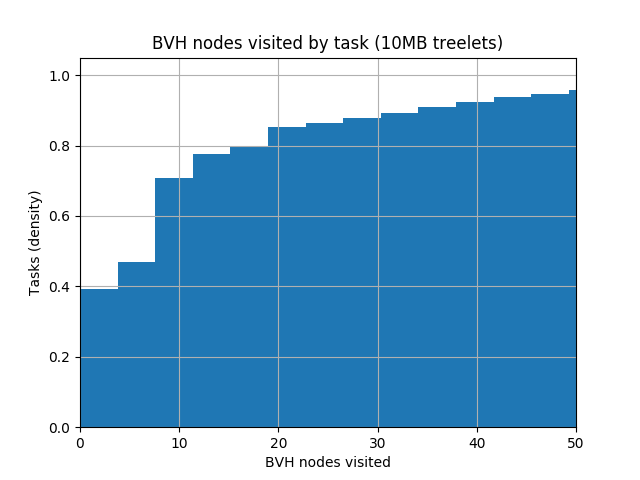

(0, 50)

In [17]:
df = bmw10m_parsed['tasks'][bmw10m_parsed['tasks'].taskType == TASK_TYPE_TRACE]
plt.figure()
df.bvhNodesVisited.hist(cumulative=True, density=1, bins=100)
plt.xlabel('BVH nodes visited')
plt.ylabel('Tasks (density)')
plt.title("BVH nodes visited by task (10MB treelets)")
plt.xlim(0, 50)